In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

Using TensorFlow backend.


In [2]:
# This function lists out all permutations of ace values in the array sum_array
# For example, if you have 2 aces, there are 4 permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums: [2, 12, 22]
# Of these 3, only 2 are <=21 so they are returned: [2, 12]
def get_ace_values(temp_list):
    sum_array = np.zeros((2**len(temp_list), len(temp_list)))
    # This loop gets the permutations
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep*2**n : rep*2**n+half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # Only return values that are valid (<=21)
    # return list(set([int(s) for s in np.sum(sum_array, axis=1) if s<=21]))
    return [int(s) for s in np.sum(sum_array, axis=1)]

# Convert num_aces, an int to a list of lists
# For example if num_aces=2, the output should be [[1,11],[1,11]]
# I require this format for the get_ace_values function
def ace_values(num_aces):
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_values(temp_list)

In [3]:
# Make a deck
def make_decks(num_decks, card_types):
    new_deck = []
    for i in range(num_decks):
        for j in range(4):
            new_deck.extend(card_types)
    random.shuffle(new_deck)
    return new_deck

# Total up value of hand
def total_up(hand):
    aces = 0
    total = 0
    
    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1
    
    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(aces)
    final_totals = [i+total for i in ace_value_list if i+total<=21]
    
    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)
    
# Play a game of blackjack (after the cards are dealt)
def play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stay):
    action = 0
    # Dealer checks for 21
    if set(dealer_hand) == blackjack:
        for player in range(players):
            if set(player_hands[player]) != blackjack:
                curr_player_results[0,player] = -1
            else:
                curr_player_results[0,player] = 0
    else:
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack:
                curr_player_results[0,player] = 1
            else:
                # Hit randomly, check for busts
                if (hit_stay >= 0.5) and (total_up(player_hands[player]) != 21):
                    player_hands[player].append(dealer_cards.pop(0))
                    action = 1
                    live_total.append(total_up(player_hands[player]))
                    if total_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1

    # Dealer hits based on the rules
    while total_up(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))
    # Compare dealer hand to players hand but first check if dealer busted
    if total_up(dealer_hand) > 21:
        for player in range(players):
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        for player in range(players):
            if total_up(player_hands[player]) > total_up(dealer_hand):
                if total_up(player_hands[player]) <= 21:
                    curr_player_results[0,player] = 1
            elif total_up(player_hands[player]) == total_up(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
                
    return curr_player_results, dealer_cards, action

In [4]:
stacks = 50000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(total_up(player_hands[player]))
        
        if stack < 25000:
            hit_stay = 1
        else:
            hit_stay = 0
        curr_player_results, dealer_cards, action = play_game(dealer_hand, player_hands, 
                                                              blackjack, curr_player_results, 
                                                              dealer_cards, hit_stay)
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['Y'] = [i[0] for i in player_results]
lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct

In [5]:
sum(pd.DataFrame(player_results)[0].value_counts())

322248

In [6]:
pd.DataFrame(player_results)[0].value_counts()

-1.0    193003
 1.0    113079
 0.0     16166
Name: 0, dtype: int64

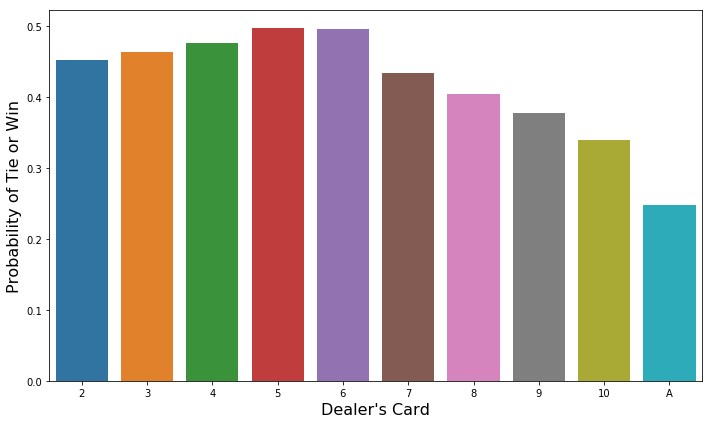

In [7]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] /\
            model_df.groupby(by='dealer_card').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
# plt.savefig(fname='dealer_card_probs', dpi=150)

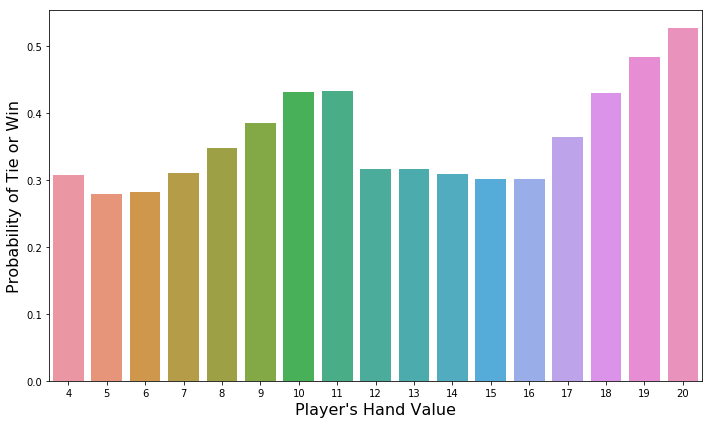

In [8]:
data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
# plt.savefig(fname='player_hand_probs', dpi=150)

In [9]:
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']

has_ace
0    0.642137
1    0.351310
Name: lose, dtype: float64

Text(123.0, 0.5, "Dealer's Card")

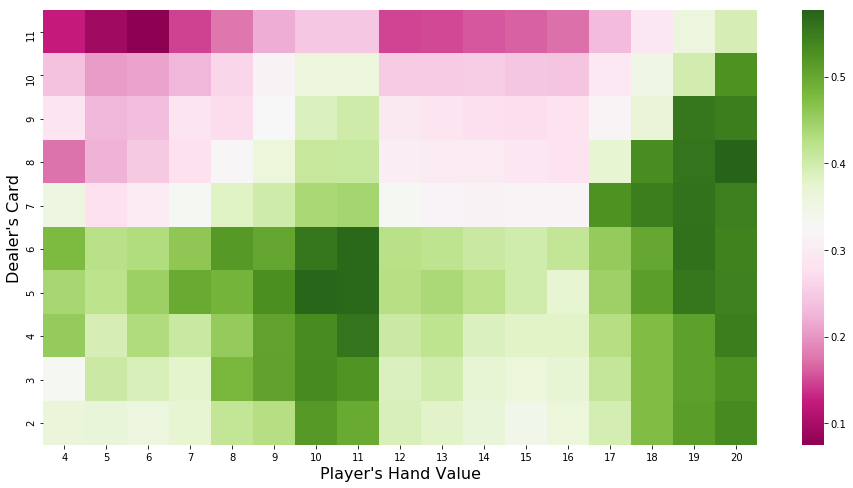

In [10]:
pivot_data = model_df[model_df['player_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Dealer's Card",fontsize=16)

# plt.savefig(fname='heat_map_random', dpi=150)

In [11]:
stacks = 50000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Hit only when we know we will not bust
                    while total_up(player_hands[player]) <= 11:
                        player_hands[player].append(dealer_cards.pop(0))
                        if total_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if total_up(player_hands[player]) > total_up(dealer_hand):
                    if total_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif total_up(player_hands[player]) == total_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        #print('player: ' + str(total_up(player_hands[player])),
        #      'dealer: ' + str(total_up(dealer_hand)),
        #      'result: ' + str(curr_player_results)
        #     )    
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))

model_df_naive = pd.DataFrame()
model_df_naive['dealer_card'] = dealer_card_feature
model_df_naive['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df_naive['Y'] = [i[0] for i in player_results]

lose = []
for i in model_df_naive['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_naive['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_naive['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_naive['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_naive['dealer_card_num'] = dealer_card_num

In [22]:
# Train a neural net to play blackjack

# Set up variables for neural net
feature_list = [i for i in model_df.columns if i not in ['dealer_card',
                                                         'Y','lose',
                                                         'correct_action']]
print(feature_list)
train_X = np.array(model_df[feature_list])
train_Y = np.array(model_df['correct_action']).reshape(-1,1)

# Set up a neural net with 5 layers
model = Sequential()
model.add(Dense(16))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_X, train_Y, epochs=20, batch_size=256, verbose=1)

pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
Epoch 1/20
322248/322248 [==============================] - 2s 6us/step - loss: 0.6718
Epoch 2/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6228
Epoch 3/20
322248/322248 [==============================] - 2s 7us/step - loss: 0.6181
Epoch 4/20
322248/322248 [==============================] - 2s 6us/step - loss: 0.6167
Epoch 5/20
322248/322248 [==============================] - 2s 6us/step - loss: 0.6160
Epoch 6/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6156
Epoch 7/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6152
Epoch 8/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6148
Epoch 9/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6149
Epoch 10/20
322248/322248 [==============================] - 2s 5us/step - loss: 0.6147
Epoch 11/20
322248/322248 [==============================] - 2s 5u

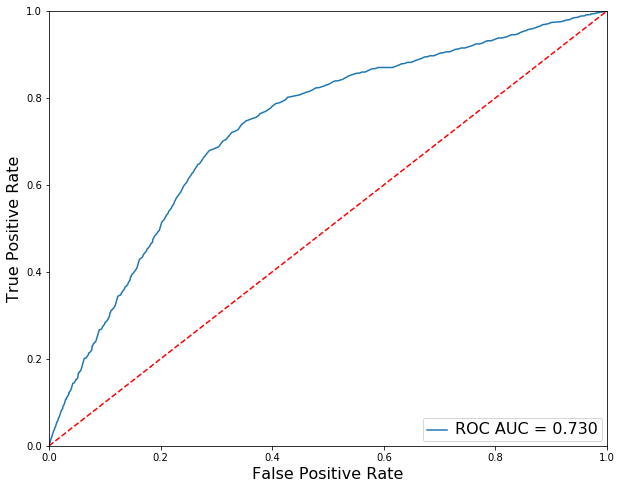

In [41]:
# Plot ROC Curve

fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)

plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

In [34]:
# Given the relevant inputs, the function below uses the neural net to make a prediction
# and then based on that prediction, decides whether to hit or stay

def model_decision(model, player_sum, has_ace, dealer_card_num):
    input_array = np.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [35]:
# Play blackjack but use the neural net to make hit/stay decision

stacks = 50000
players = 1
num_decks = 1

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = make_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(total_up(player_hands[player]))
        action = 0

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Neural net decides whether to hit or stay
                    if 'A' in player_hands[player][0:2]:
                        ace_in_hand = 1
                    else:
                        ace_in_hand = 0
                    if dealer_hand[0] == 'A':
                        dealer_face_up_card = 11
                    else:
                        dealer_face_up_card = dealer_hand[0]
                    
                    while (model_decision(model, total_up(player_hands[player]), 
                                          ace_in_hand, dealer_face_up_card) == 1) and (total_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                        live_total.append(total_up(player_hands[player]))
                        if total_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if total_up(player_hands[player]) > total_up(dealer_hand):
                    if total_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif total_up(player_hands[player]) == total_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df_smart = pd.DataFrame()
model_df_smart['dealer_card'] = dealer_card_feature
model_df_smart['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature]
model_df_smart['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_smart['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_smart['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_smart['dealer_card_num'] = dealer_card_num

model_df_smart['Y'] = [i[0] for i in player_results]
lose = []
for i in model_df_smart['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_smart['lose'] = lose

In [145]:
print('Random: ' + str(round(model_df[model_df['Y']==1].shape[0]/model_df.shape[0], 4)))
print('Random: ' + str(round(model_df_naive[model_df_naive['Y']==1].shape[0]/model_df_naive.shape[0], 4)))
print('Random: ' + str(round(model_df_smart[model_df_smart['Y']==1].shape[0]/model_df_smart.shape[0], 4)))

Random: 0.3509
Random: 0.4148
Random: 0.4194


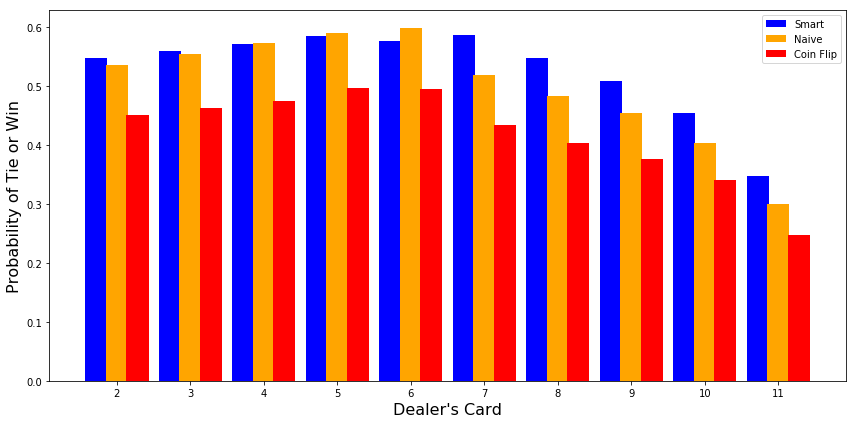

In [36]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['naive'] = data_naive
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.28, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_smart', dpi=150)

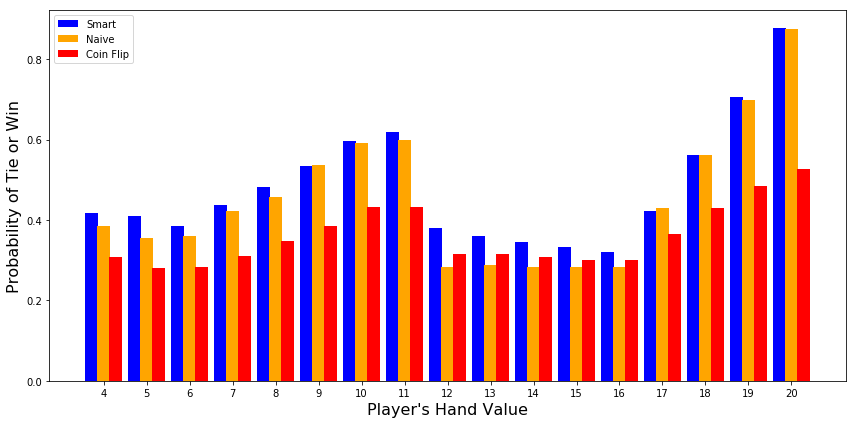

In [37]:
data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_smart.groupby(by='player_total_initial').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_naive.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart[:-1]
data['naive'] = data_naive[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.28, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_smart', dpi=150)

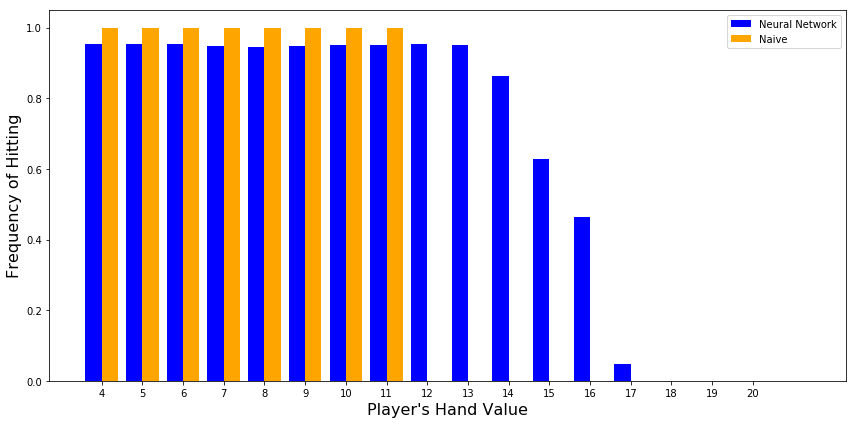

In [52]:
# Check out the probability of hitting for various player hand totals
game_count_df = model_df_smart.groupby(by=['player_total_initial']).count()['lose']
game_count = np.array(game_count_df)
hit_count = list(model_df_smart[model_df_smart['hit?']==1].groupby(by=['player_total_initial']).count()['lose'])
hit_count.extend([0 for i in range(len(game_count) - len(hit_count))])
hit_rate_df = pd.DataFrame(np.array(hit_count)/np.array(game_count), index=game_count_df.index, 
                           columns=['neural net hit frequency'])
hit_rate_df.reset_index(inplace=True)
hit_rate_df

naive_hit_rate = []
for i in range(4,22):
    if i < 12:
        naive_hit_rate.append(1.0)
    else:
        naive_hit_rate.append(0.0)
hit_rate_df['naive strategy hit frequency'] = naive_hit_rate

data = hit_rate_df[['neural net hit frequency','naive strategy hit frequency']]
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=hit_rate_df['player_total_initial']-0.2, 
       height=data['neural net hit frequency'].values, color='blue', width=0.4, label='Neural Network')
ax.bar(x=hit_rate_df['player_total_initial']+0.2, 
       height=data['naive strategy hit frequency'].values, color='orange', width=0.4, label='Naive')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Frequency of Hitting",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='hit_frequency', dpi=150)

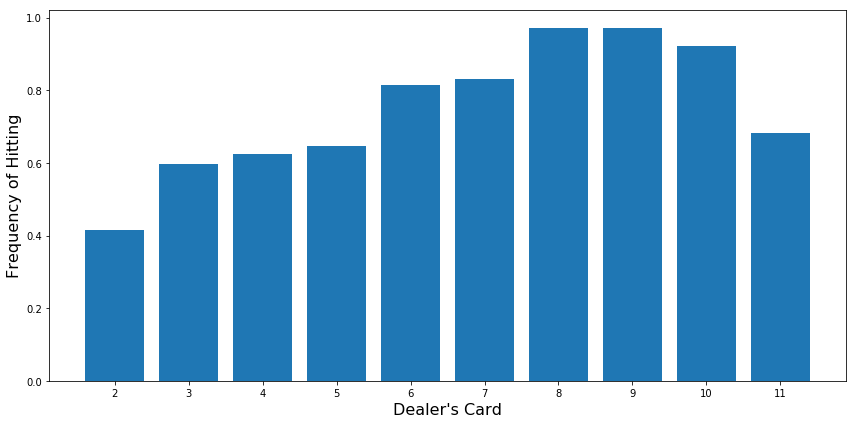

In [146]:
# Calculate and graph the neural net's hit frequency vs. dealer card for
# player hands in [12,13,14,15,16]
player_despair_df = model_df_smart[(model_df_smart['player_total_initial']==12) |\
                              (model_df_smart['player_total_initial']==13) |\
                              (model_df_smart['player_total_initial']==14) |\
                              (model_df_smart['player_total_initial']==15) |\
                              (model_df_smart['player_total_initial']==16)].\
                   groupby(by=['dealer_card_num','hit?']).count()['lose']
player_despair_df2 = player_despair_df.reset_index().copy()

hit_rate_despair = np.array(player_despair_df2[player_despair_df2['hit?']==1])[:,-1]/\
                   np.array(player_despair_df2.groupby(by='dealer_card_num').sum())[:,-1]

data = pd.DataFrame(hit_rate_despair, 
                    index=player_despair_df2.groupby(by='dealer_card_num').sum().index,
                    columns = ['hit_rate'])
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index, height=data['hit_rate'].values)
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Frequency of Hitting",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.tight_layout()
plt.savefig(fname='hit_frequency', dpi=150)

In [180]:
print('Total hit frequency: ' +\
      str(round(model_df_smart[model_df_smart['hit?']==1].shape[0]/np.sum(model_df_smart.shape[0]), 4)))

Total hit frequency: 0.554
